In [3]:
from dask import delayed, visualize
import dask_geopandas as dask_gpd
import functions as f
import geopandas as gpd
import shapely

# Info

With 2_000_000 objects due to the memory consrtraints the buffer and unary union method doest work. Thats why we implemented a dask solution whihc parallize the process. 

The simple method was able to finish the process under 16:21 min (close to run out the memory), my own implementation finishes it within 15 min (memory friendly). This implementation is failed with 16 partitions, however, we havent run put the memory, or something shit happened

C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65427 instead
  warnings.warn(
C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 185.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-05-01 20:47:02,527 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:65456 (pid=17256) exceeded 95% memory budget. Restarting...
2024-05-01 20:47:02,558 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:65456' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'UnaryUnion-05b6f3e1-e6e4-48f9-80a0-87fc236de0a8', 'UnaryUnion-0cf67659-628f-484f-aa06-7c638d995704'} (stimulus_id='handle-worker-cleanup-1714589222.5569327')
2024-05-01 20:47:05,968 - distributed.nanny - WARNING - Restarting worker" 



FIX THIS: 

C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54187 instead
  warnings.warn(

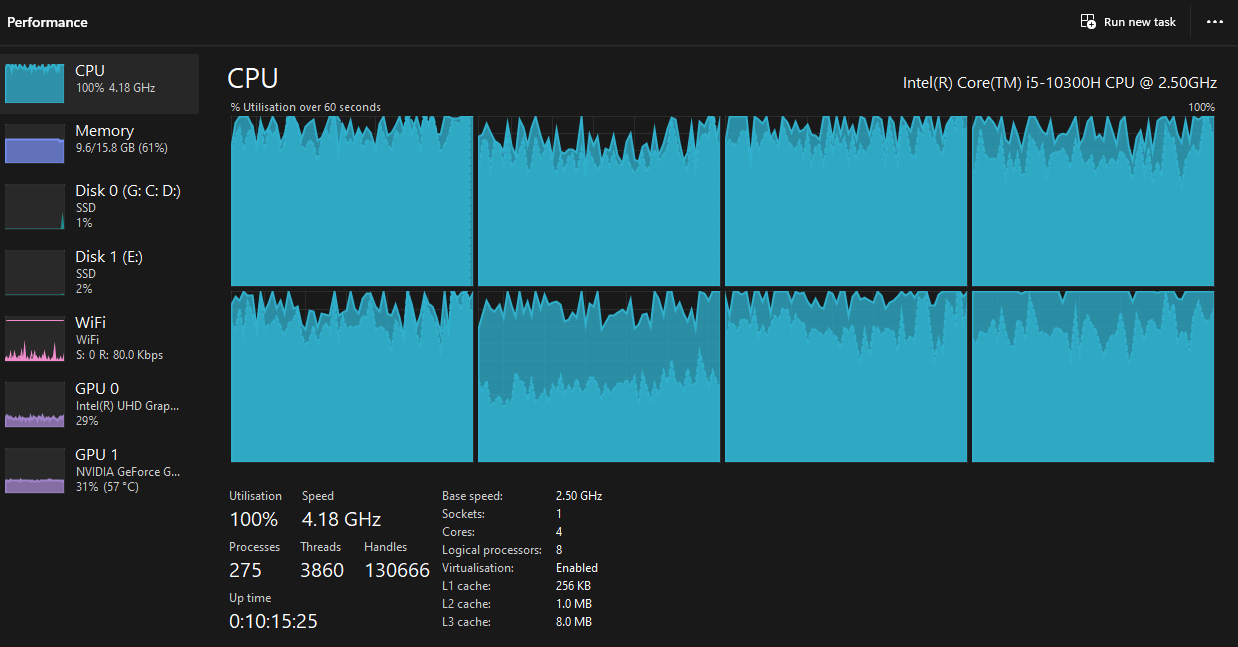

Another issue is: The graph builder sometimes is wrong (this is the biggest WTF) Meaning the task graph is not connected, so I have to re-run the whole shit (?????)

This is good 
# size 
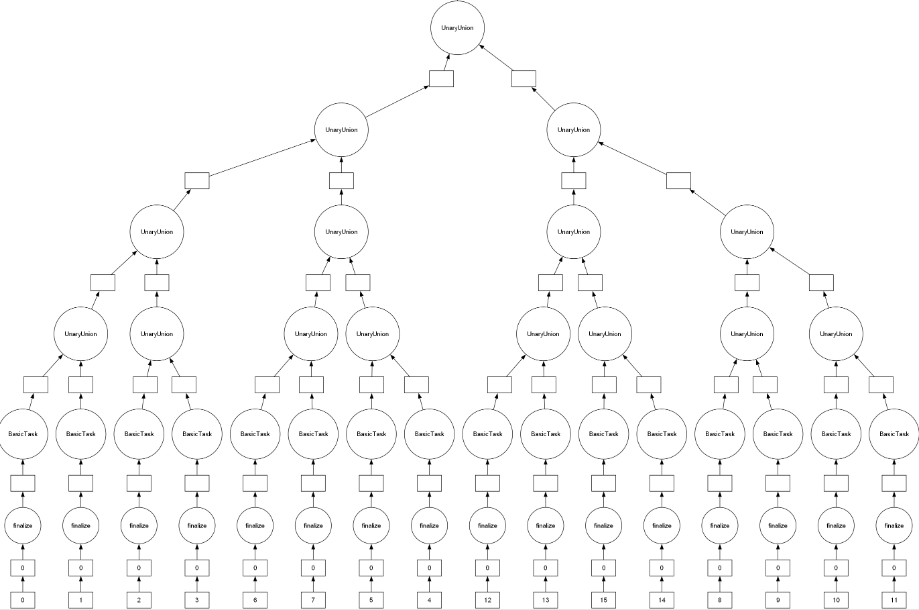{width=200%}

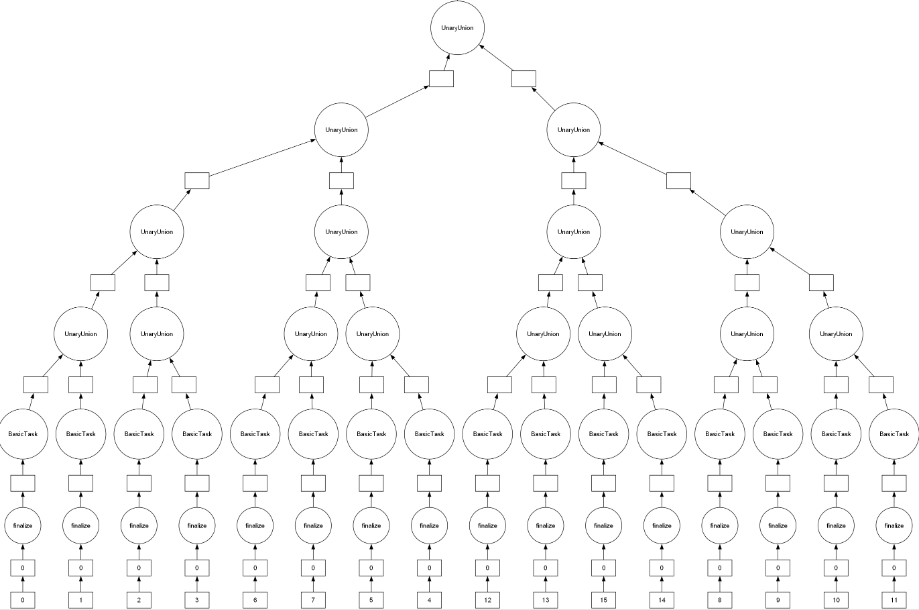

#### Dask is unrelieable 

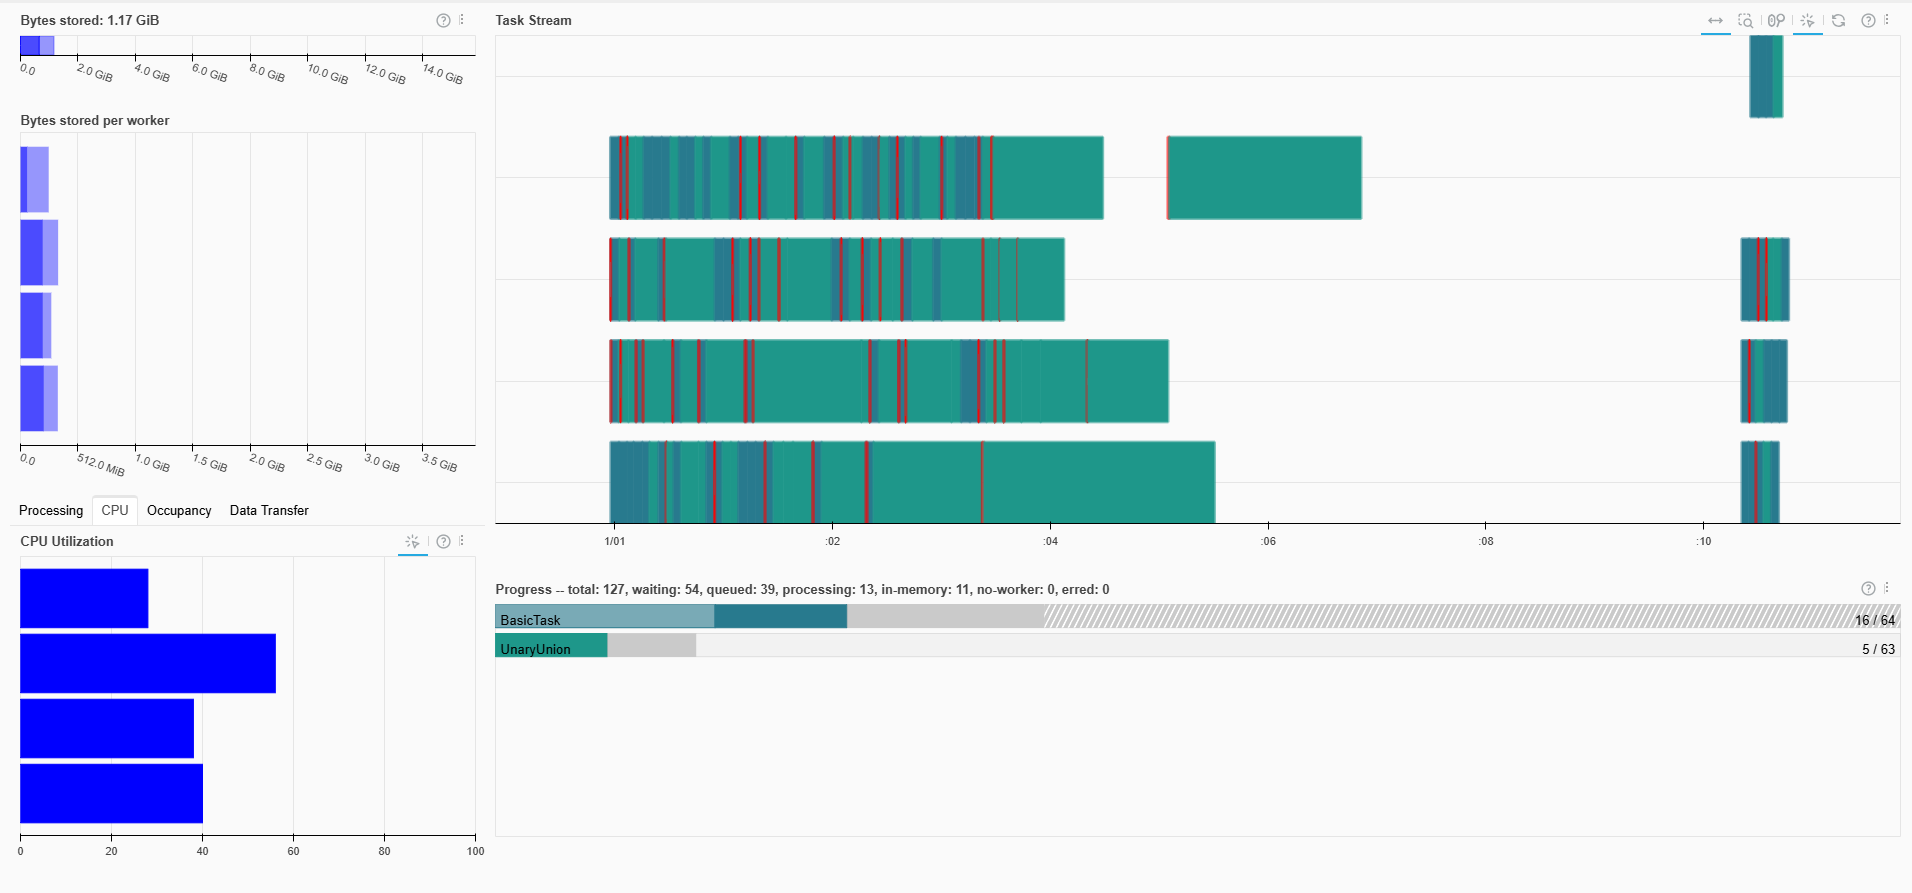

C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 46.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-05-02 09:11:36,632 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:54539 (pid=13408) exceeded 95% memory budget. Restarting...
2024-05-02 09:11:36,639 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:54539' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'UnaryUnion-e1be441c-3dfa-49ae-8fdc-46e12265a6d7', 'UnaryUnion-da68c5f8-6a63-466a-8ea0-c0a9ee448f0c'} (stimulus_id='handle-worker-cleanup-1714633896.6404276')
2024-05-02 09:11:37,150 - distributed.nanny - WARNING - Restarting worker

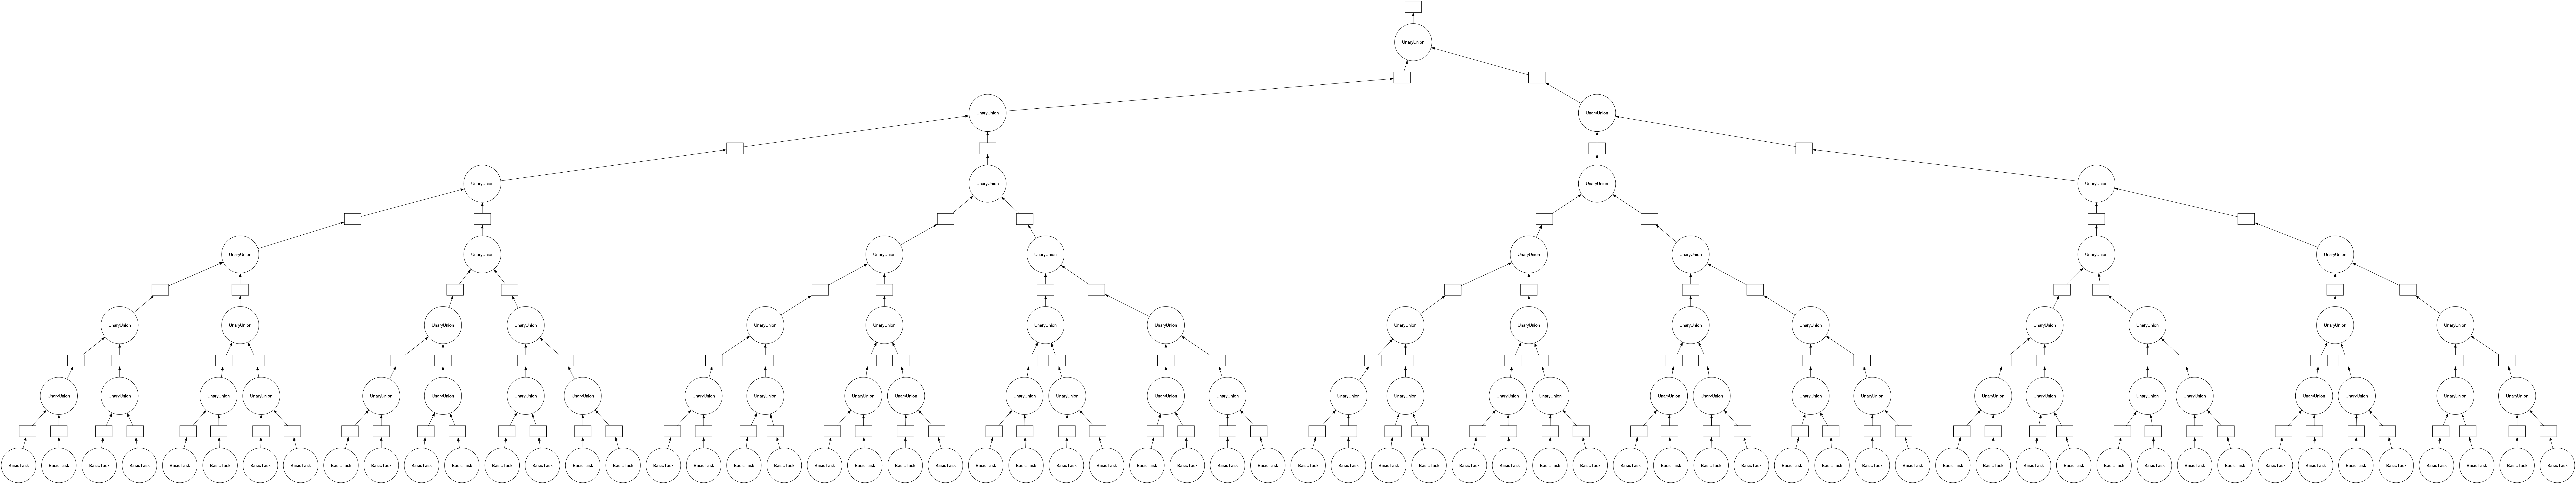

# DASK implementation

In [66]:
BUFFER = 40
SAMPLE = 2_000_000
SAMPLE = 500_000
RESOLUTION = 16
SAMPLE = 50_000

In [67]:
bikelane_wgs84 = gpd.read_parquet('dataset/raw_unprocessed/bikelane_dk_WGS84_h3_indexed.parquet')
bikelane_wgs84_demo = bikelane_wgs84.sample(SAMPLE)
# bikelane_wgs84_demo = bikelane_wgs84
bikelane_wgs84_demo.sort_values('h3_index', inplace=True)


In [71]:
bikelane_wgs84['geometry'] = bikelane_wgs84.buffer(0)

In [68]:
valid_geometries = bikelane_wgs84[bikelane_wgs84.is_valid]

In [69]:
valid_geometries

geometry  \
u           v           key                                                      
676544      443246370   0    LINESTRING (12.21994 55.35135, 12.21919 55.34960)   
            676545      0    LINESTRING (12.21994 55.35135, 12.22056 55.35124)   
            443245726   0    LINESTRING (12.21994 55.35135, 12.22020 55.351...   
726713      443257088   0    LINESTRING (12.22800 55.34623, 12.22566 55.34618)   
            1478811288  0    LINESTRING (12.22800 55.34623, 12.22810 55.34556)   
...                                                                        ...   
11755267988 11755267989 0    LINESTRING (10.15522 55.55155, 10.15432 55.55146)   
            1722039621  0    LINESTRING (10.15522 55.55155, 10.15523 55.551...   
11755267989 11755267988 0    LINESTRING (10.15432 55.55146, 10.15522 55.55155)   
11755267999 1316680106  0    LINESTRING (10.12222 55.57623, 10.12257 55.576...   
11755268000 1316680106  0    LINESTRING (10.12260 55.57816, 10.12216 55.57802)   

                                    h3_index  
u           v           key                   
676544      443246370   0    8663a9637ffffff  
            676545      0    8663a9637ffffff  
            443245726   0    8663a9637ffffff  
726713      443257088   0    8663a9637ffffff  
            1478811288  0    8663a9637ffffff  
...                                      ...  
11755267988 11755267989 0    866389acfffffff  
            1722039621  0    866389acfffffff  
11755267989 11755267988 0    866389acfffffff  
11755267999 1316680106  0    866389367ffffff  
11755268000 1316680106  0    866389367ffffff  

[3257915 rows x 2 columns]

In [63]:
bikelane_wgs84_demo = bikelane_wgs84_demo.reset_index(drop=True)
bikelane_dk_demo = bikelane_wgs84_demo.to_crs(f.DENMARK_CRS)
#bikelane_dk_demo.geometry = shapely.set_precision(bikelane_dk_demo.geometry, grid_size=1)
len(bikelane_dk_demo)

500000

In [64]:
del bikelane_wgs84
del bikelane_wgs84_demo

#### Geodask? 

In [65]:
import dask_geopandas as dg
import geopandas as gpd
from shapely.ops import unary_union
from dask.diagnostics import ProgressBar

# Function to apply unary_union on each partition
def apply_unary_union(df):
    return gpd.GeoSeries([unary_union(df.geometry)])

# Function to apply buffer and then unary_union on each partition
def apply_buffer_and_unary_union(df):
    # Buffer the geometries in each partition
    buffered = df.geometry.buffer(BUFFER, resolution=RESOLUTION)
    # Apply unary_union to the buffered geometries
    return gpd.GeoSeries([unary_union(buffered)])

# Convert GeoDataFrame to Dask-GeoDataFrame
dask_gdf = dg.from_geopandas(bikelane_dk_demo, npartitions=8)  # Adjust npartitions based on your system
print("dask is ready")
# Apply buffer and unary_union on each partition
buffered_and_unified = dask_gdf.map_partitions(apply_buffer_and_unary_union, meta=('geometry', 'geometry'))
print("buffered_and_unified is ready")

# Persist data in memory for fast access
# below line is slow like a shit
# buffered_and_unified = buffered_and_unified.persist()
# print("buffered_and_unified is persisted")

# Optionally, compute the result, which triggers the computation across partitions
with ProgressBar():
    result = buffered_and_unified.compute()
print("result is ready")
# If needed, further reduce to single geometry
#final_result = unary_union(result.geometry)
final_result = f.geoseries_to_geopandas(result, f.DENMARK_CRS)
print("final_result is ready")

#final_result = f.geoseries_to_geopandas(final_result, f.DENMARK_CRS)

final_result.to_parquet('dataset/raw_unprocessed/bikelane_FINAL.parquet')

dask is ready
buffered_and_unified is ready
[########################################] | 100% Completed | 75.19 s
result is ready
final_result is ready


In [4]:
# drop multi index
PARTITIONS = 64
bikelane_wgs84_demo = bikelane_wgs84_demo.reset_index(drop=True)
bikelane_dk_demo = bikelane_wgs84_demo.to_crs(f.DENMARK_CRS)
d_gdf = dask_gpd.from_geopandas(bikelane_dk_demo, npartitions=PARTITIONS)

In [5]:
import geopandas as gpd
import pandas as pd
from dask import delayed
import dask_geopandas as dgpd
from dask.distributed import Client, progress, LocalCluster, get_client

In [6]:
d_gdf = dgpd.from_geopandas(bikelane_dk_demo, npartitions=PARTITIONS)
try:
    del bikelane_wgs84
    del bikelane_wgs84_demo
except:
    None

In [7]:
d_gdf.persist()

,geometry,h3_index
npartitions=64,,
0,geometry,string
7813,...,...
...,...,...
492188,...,...
499999,...,...


In [8]:
@delayed
def BasicTask(gdf):

    gdf = gdf.buffer(BUFFER)

    gdf = f.geoseries_to_geopandas(gdf, crs=f.DENMARK_CRS)
    gdf = f.multipolygon_to_gdf(gdf.unary_union, crs=f.DENMARK_CRS)

    #gdf = DENMARK.intersection(gdf)

    #gdf = f.geoseries_to_geopandas(gdf, crs=f.DENMARK_CRS)
    #done.to_parquet(f'dataset/processed/bikelane_{t}_minutes_dk.parquet')
    return gdf

@delayed
def UnaryUnion(gdf1, gdf2):
    # Assuming gdf1 and gdf2 are your GeoDataFrames
    combined_gdf = gpd.GeoDataFrame(pd.concat([gdf1.geometry, gdf2.geometry], ignore_index=True))

    # Now compute the unary union
    #unary_union_result = combined_gdf.explode().unary_union
    unary_union_result = combined_gdf.unary_union
    gdf = f.multipolygon_to_gdf(unary_union_result, crs=f.DENMARK_CRS)

    return gdf

# Load and process partitions
load = [BasicTask(d_gdf.get_partition(i).compute()) for i in range(PARTITIONS)]

# Recursive function to reduce partitions by applying UnaryUnion
def reduce_partitions(partitions):
    if len(partitions) <= 1:
        return partitions
    reduced = []
    for i in range(0, len(partitions), 2):
        if i + 1 < len(partitions):
            reduced.append(UnaryUnion(partitions[i], partitions[i+1]))
        else:
            reduced.append(partitions[i])
    return reduce_partitions(reduced)

final_result = reduce_partitions(load)

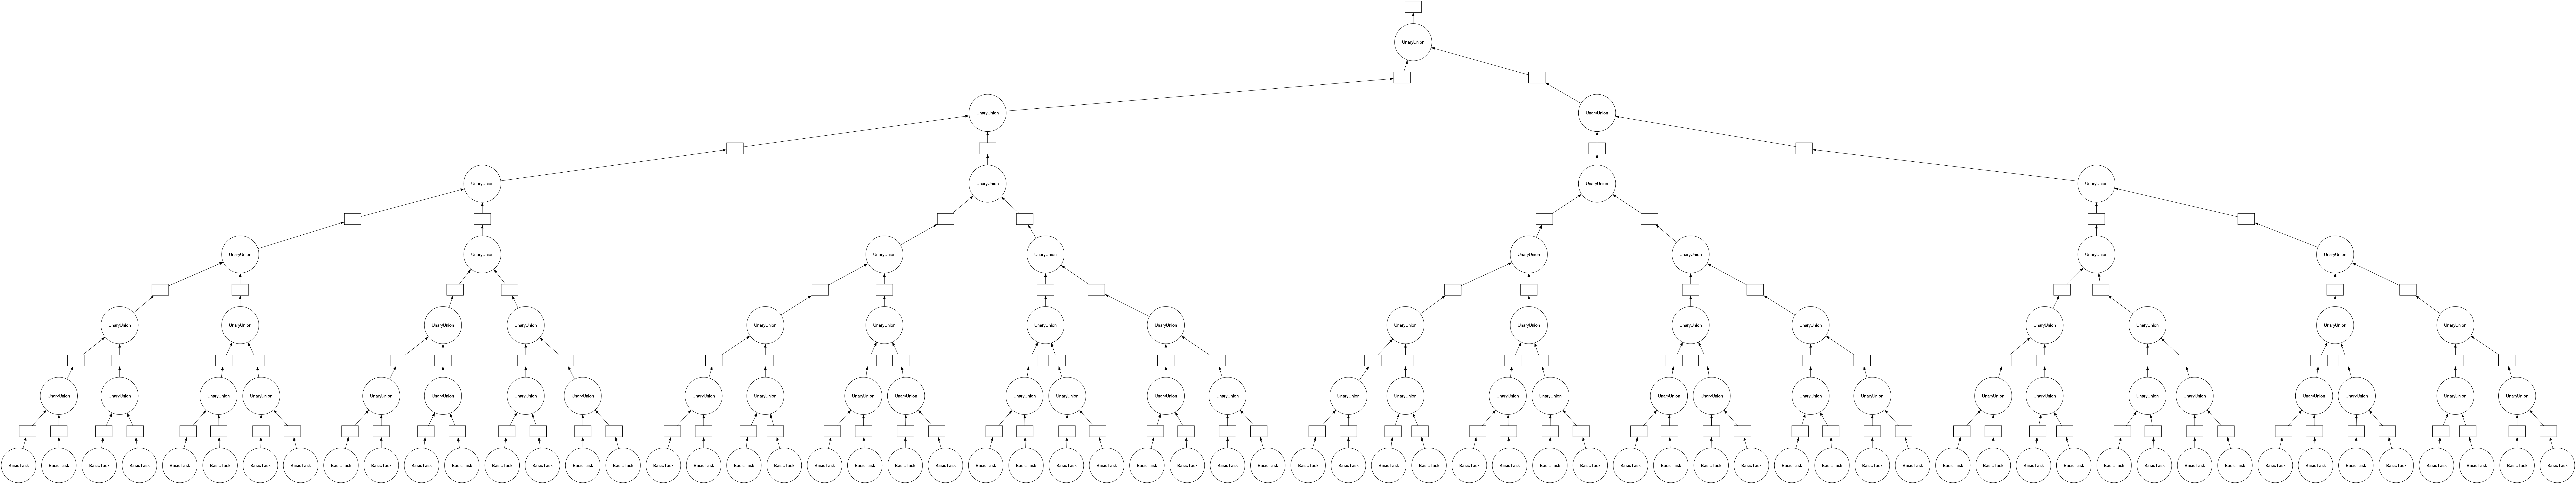

In [9]:
visualize(final_result)

In [10]:
import atexit


# Function to close Dask resources
def close_dask_resources():
    try:
        client = get_client()
        client.close()
        print('Closed Dask client')
    except ValueError:
        print('No Dask client to close')
    
    try:
        if 'cluster' in globals():
            cluster.close()
            print('Closed Dask cluster')
    except NameError:
        print('No Dask cluster to close')

In [14]:
try:
    client = get_client()
    client.close()
    print('Closed existing client')
except ValueError:
    print('No existing client to close')
    pass  # No client was running


cluster = LocalCluster(dashboard_address='127.0.0.1:8787',
                        worker_dashboard_address='127.0.0.1:8787',
                        n_workers=4,
                        threads_per_worker=1)

client = Client(cluster)

atexit.register(close_dask_resources)

No existing client to close


<function __main__.close_dask_resources()>

In [15]:
result = client.compute(final_result[0])
final_result_df = result.result()

C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 46.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2024-05-02 09:11:36,632 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:54539 (pid=13408) exceeded 95% memory budget. Restarting...
2024-05-02 09:11:36,639 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:54539' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'UnaryUnion-e1be441c-3dfa-49ae-8fdc-46e12265a6d7', 'UnaryUnion-da68c5f8-6a63-466a-8ea0-c0a9ee448f0c'} (stimulus_id='handle-worker-cleanup-1714633896.6404276')
2024-05-02 09:11:37,150 - distributed.nanny - WARNING - Restarting worker


In [37]:
import bokeh

In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59083/status,
Dashboard: http://127.0.0.1:59083/status,Workers: 8
Total threads: 8,Total memory: 15.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59089,Workers: 8
Dashboard: http://127.0.0.1:59083/status,Total threads: 8
Started: 8 minutes ago,Total memory: 15.84 GiB
Comm: tcp://127.0.0.1:59149,Total threads: 1
Dashboard: http://127.0.0.1:59150/status,Memory: 1.98 GiB
Nanny: tcp://127.0.0.1:59092,
